In [1]:
import awkward1 as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import numpy as np
from tqdm import tqdm,trange
import matplotlib.pyplot as plt
import numba

In [2]:
infile = "data/signal/wza_UL18.root" # --signal
#infile='data/data/7B56E217-555E-1C41-9494-491849A9835F_skim_2ElIdPt20.root' # --data 
#infile="data/mc/59AB328B-F0E3-F544-98BB-E5E55577C649_skim_2ElIdPt20.root" # --mc

In [3]:
events = NanoEventsFactory.from_root(infile, schemaclass=NanoAODSchema).events()

In [4]:
# Trigger set
year='2018'

doubleelectron_triggers  ={
    '2018': [
            "Ele23_Ele12_CaloIdL_TrackIdL_IsoVL", # Recomended
            ]
}

singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
        '2016': [
            'Ele27_WPTight_Gsf',
            'Ele105_CaloIdVT_GsfTrkIdT'
        ],
        '2017': [
            'Ele35_WPTight_Gsf',
            'Ele115_CaloIdVT_GsfTrkIdT',
            'Photon200'
        ],
        '2018': [
            'Ele32_WPTight_Gsf',   # Recomended
        ]
}

In [5]:
# double lepton trigger
is_double_ele_trigger=True
if not is_double_ele_trigger:
    double_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    double_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in doubleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        double_ele_triggers_arr = double_ele_triggers_arr | events.HLT[path]


# single lepton trigger
is_single_ele_trigger=True
if not is_single_ele_trigger:
    single_ele_triggers_arr=np.ones(len(events), dtype=np.bool)
else:
    single_ele_triggers_arr = np.zeros(len(events), dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.fields: continue
        single_ele_triggers_arr = single_ele_triggers_arr | events.HLT[path]

In [6]:
# -- Helper function: Flat dimension and pop NaN
def flat_dim(arr):

    sub_arr = ak.flatten(arr)
    mask = ~ak.is_none(sub_arr)

    return ak.to_numpy(sub_arr[mask])

In [7]:
# -- Helper function: Sort paricles by PT-order
def sort_by_pt(ele,pho,jet):
    ele = ele[ak.argsort(ele.pt,ascending=False,axis=1)]
    pho = pho[ak.argsort(pho.pt,ascending=False,axis=1)]
    jet = jet[ak.argsort(jet.pt,ascending=False,axis=1)]

    return ele,pho,jet

In [8]:
# Sort particle order by PT
events.Electron,events.Photon,events.Jet = sort_by_pt(events.Electron,events.Photon,events.Jet)

In [9]:
Initial_events = events
print("#### Initial events: ",len(Initial_events))
#events = events[single_ele_triggers_arr | double_ele_triggers_arr]
events = events[double_ele_triggers_arr]
print("#### Passing Trigger: ",len(events))

#### Initial events:  55000
#### Passing Trigger:  9544


### 1. Particle Selection

In [10]:
Electron = events.Electron
Photon   = events.Photon
Jet      = events.Jet

In [11]:
print(len(Electron),len(Photon))

9544 9544


In [46]:
def Particle_selection(ele,pho):
    # Electron selection
    EleSelmask = ((ele.pt > 25) & (np.abs(ele.eta + ele.deltaEtaSC) < 1.4442) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.05) & (abs(ele.dz) < 0.1)) | \
                ((ele.pt > 25) & (np.abs(ele.eta + ele.deltaEtaSC) > 1.5660) & (ele.cutBased > 2) & (abs(ele.dxy) < 0.05) & (abs(ele.dz) < 0.1))
    
    # Photon selection
    # 0 Fail 1 Loose 2 Medium 3 Tight
    # -- HoE cut is added manually
    #PhoSelmaskEE = (pho.pt > 25) & (pho.cutBased > 1) &  pho.isScEtaEE & (pho.hoe < 0.0326)
    #PhoSelmaskEB = (pho.pt > 25) & (pho.cutBased > 1) &  pho.isScEtaEB & (pho.hoe < 0.02197)
    #PhoSelmask = PhoSelmaskEE | PhoSelmaskEB
    
    # -- Original Photon selection
    
    isgap_mask = (abs(photon.eta) < 1.442)  |  ((abs(photon.eta) > 1.566) & (abs(photon.eta) < 2.5))
    Pixel_seed_mask   = ~pho.pixelSeed
    PhoSelmask = (pho.pt > 25) & (pho.cutBased > 1) & isgap_mask &  Pixel_seed_mask
        
    return EleSelmask,PhoSelmask

In [47]:
# Event Selection
Electron_mask, Photon_mask  = Particle_selection(Electron,Photon)

#Ele_channel_mask = ak.num(Electron[Electron_mask])  > 1
Ele_channel_mask = ak.num(Electron[Electron_mask]) == 3
Pho_channel_mask = ak.num(Photon[Photon_mask]) > 0

Ele_channel_events = events[Ele_channel_mask & Pho_channel_mask]

In [48]:
print("Events: {0} --> {1} ".format(len(events), len(Ele_channel_events)))

Events: 9544 --> 504 


### 2. Make Paricle array from selected events

In [15]:
Electron = Ele_channel_events.Electron
Photon = Ele_channel_events.Photon
Jet = Ele_channel_events.Jet

In [16]:
Electron_mask,Photon_mask,_ = Particle_selection(Electron,Photon,Jet)
Electron = Electron[Electron_mask]
Photon = Photon[Photon_mask]
Jet = Jet

### 3. OSSF

In [17]:
@numba.njit
def find_3lep(events_leptons,builder):
    
    for leptons in events_leptons:
        builder.begin_list()    
        nlep = len(leptons)
        
        for i0 in range(nlep):
            for i1 in range(i0+1,nlep):
                if leptons[i0].charge + leptons[i1].charge != 0: continue;
                
                for i2 in range(nlep):
                    if len({i0,i1,i2}) < 3: continue;
                    builder.begin_tuple(3)
                    builder.index(0).integer(i0)
                    builder.index(1).integer(i1)
                    builder.index(2).integer(i2)
                    builder.end_tuple()
        builder.end_list()
    return builder

In [18]:
%%time
eee_triplet_idx = find_3lep(Electron,ak.ArrayBuilder()).snapshot()

CPU times: user 672 ms, sys: 16.6 ms, total: 689 ms
Wall time: 688 ms


In [19]:
ossf_mask = ak.num(eee_triplet_idx) == 2
eee_triplet_idx = eee_triplet_idx[ossf_mask]


Electron= Electron[ossf_mask]
Photon= Photon[ossf_mask]
Jet= Jet[ossf_mask]

In [20]:
# eee_triplet_idx["0"] = eee_triplet_idx[:][:]["0"]
Triple_electron = [Electron[eee_triplet_idx[idx]] for idx in "012"]

In [21]:
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

def TLorentz_vector(vec):
    vec = ak.zip(
    {
            "x":vec.x,
            "y":vec.y,
            "z":vec.z,
            "t":vec.t
    },
    with_name = "LorentzVector"
    )
    return vec

In [49]:
def TLorentz_vector_cylinder(vec):

    vec = ak.zip(
    {
        "pt": vec.pt,
        "eta": vec.eta,
        "phi": vec.phi,
        "mass": vec.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
    )
    
    return vec

In [22]:
Triple_eee = ak.zip({"lep1":Triple_electron[0],
                     "lep2":Triple_electron[1],
                   "lep3":Triple_electron[2],
                   "p4":TLorentz_vector(Triple_electron[0]+Triple_electron[1])})

In [23]:
bestZ_idx = ak.singletons(ak.argmin(abs(Triple_eee.p4.mass - 91.1876), axis=1))

In [24]:
Triple_eee = Triple_eee[bestZ_idx]

In [25]:
print(Triple_eee.p4.mass)

[[90.3], [56.5], [59.8], [57.7], [90.3], ... [92.3], [55.4], [61.1], [60.6], [86.4]]


In [47]:
Triple_eee.lep1.mass

<Array [[0.00818], [-0.00475, ... [-0.0112]] type='51 * var * float32[parameters...'>

### 4. Select Photon with dR < 0.4

In [57]:
leading_ele, subleading_ele = ak.flatten(TLorentz_vector_cylinder(Triple_eee.lep1)),ak.flatten(TLorentz_vector_cylinder(Triple_eee.lep2))

def make_DR(ele1,ele2,pho,jet):
      
    dR_e1pho  = ele1.delta_r(pho)
    dR_e2pho  = ele2.delta_r(pho)
    dR_phojet = jet[:,0].delta_r(pho)
    dR_mask   = (dR_e1pho > 0.4) & (dR_e2pho > 0.4) & (dR_phojet > 0.4)
    
    return dR_mask,dR_e1pho,dR_e2pho,dR_phojet

In [58]:
dR_mask,dR_e1pho,dR_e2pho,dR_phojet = make_DR(leading_ele,subleading_ele,Photon,Jet)

In [59]:
print(ak.num(Photon))
print(ak.num(dR_mask))

[4, 2, 3, 4, 4, 2, 3, 3, 2, 3, 3, 4, 4, 4, ... 3, 4, 2, 3, 4, 3, 3, 4, 4, 2, 4, 2, 3]
[4, 2, 3, 4, 4, 2, 3, 3, 2, 3, 3, 4, 4, 4, ... 3, 4, 2, 3, 4, 3, 3, 4, 4, 2, 4, 2, 3]


(0.0, 1.0)

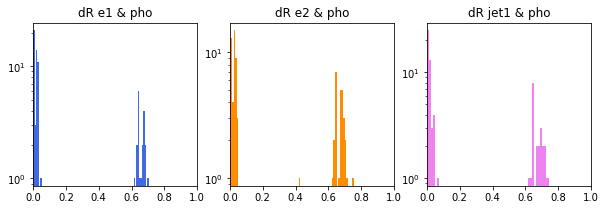

In [60]:
bins=500
fig,axs = plt.subplots(1,3,figsize=(10,3))
axs[0].hist(flat_dim(dR_e1pho),bins=bins,color='royalblue')
axs[0].set_title('dR e1 & pho')
axs[0].set_yscale('log')
axs[0].set_xlim(0,1)

axs[1].hist(flat_dim(dR_e2pho),bins=bins,color='darkorange')
axs[1].set_title('dR e2 & pho')
axs[1].set_yscale('log')
axs[1].set_xlim(0,1)

axs[2].hist(flat_dim(dR_phojet),bins=bins,color='violet')
axs[2].set_title('dR jet1 & pho')
axs[2].set_yscale('log')
axs[2].set_xlim(0,1)

In [61]:
Photon = Photon[dR_mask]

### 5. Event Selection

In [86]:
Ele_channel_with_dR = Ele_channel_events[ak.num(Photon) > 0]
Triple_eee = Triple_eee[ak.num(Photon) > 0]
Photon   = Photon[ak.num(Photon) > 0]
Jet      = Jet[ak.num(Photon) > 0]

In [87]:
Triple_eee.lep1.deltaEtaSC

<Array [[-0.012], [-0.0136, ... [0.0145]] type='38 * var * float32[parameters={"...'>

In [88]:
diele = Triple_eee.p4
zmass_window_mask = ak.firsts((diele.mass) > 60 | (diele.mass < 120))

In [89]:
eeg_vec = diele + Photon[:,0]

In [106]:
diele.pt

<Array [[271], [34.4], ... [6.03], [8.26]] type='38 * var * float32'>

In [113]:
ak.singletons(Photon[:,0]).pt

<Array [136, 25.7, 34.7, ... 136, 35.5, 35] type='38 * float32[parameters={"__do...'>

In [90]:
Meeg_mask = ak.firsts(eeg_vec.mass > 120)

In [91]:
Triple_eee_sel = Triple_eee[zmass_window_mask & Meeg_mask]
Photon_sel     = Photon[zmass_window_mask & Meeg_mask]
Jet_sel        = Jet[zmass_window_mask & Meeg_mask]

In [92]:
print("Final # of events:" ,len(Photon_sel))

Final # of events: 13


In [93]:
Triple_eee.p4.fields

['x', 'y', 'z', 't']

In [94]:
Triple_eee.lep1.charge +Triple_eee.lep2.charge

<Array [[0], [0], [0], ... [0], [0], [0]] type='38 * var * int32'>

In [95]:
print(len(Jet))

38


In [98]:
ak.flatten(Meeg_mask)

ValueError: axis out of range for flatten

(https://github.com/scikit-hep/awkward-1.0/blob/0.4.4/src/libawkward/array/NumpyArray.cpp#L1431)

In [102]:
Triple_eee.lep1.pt

<Array [[159], [34.3], ... [26.5], [31.1]] type='38 * var * float32[parameters={...'>

In [114]:
xxx =Photon_sel[Photon_sel.isScEtaEB]

In [119]:
xxxx =xxx[xxx.pt > 200]

In [126]:
len(xxx[0])

2

In [117]:
for i in xxx.pt:
    print(i)

[136, 63.3]
[141, 74.7]
[62.9]
[127, 48.3]
[144]
[25.8]
[138, 32.9]
[134, 77.7]
[136, 80.5]
[]
[132, 43.4]
[138, 47.4]
[136, 73.6]


In [127]:
x = [1,2,3]

In [129]:
print(len(x[0]))

TypeError: object of type 'int' has no len()